In [1]:
import boto3
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

### data

In [2]:
client = boto3.client('s3')

In [3]:
s3_prefix = 's3://'
bucket = 'sisyphus-general-bucket'
primary_folder = 'AthenaInsights'
data_folder = 'latest_data'

In [4]:
response = client.list_objects_v2(
    Bucket=bucket,
    Prefix=f'{primary_folder}/{data_folder}/data_prep/')

In [5]:
files = []
all_symbols = set()

In [6]:
paths = []
for content in response.get('Contents', []):
    # print(f"{s3_prefix}{bucket}/{content['Key']}")
    paths.append(f"{s3_prefix}{bucket}/{content['Key']}")

In [7]:
paths

['s3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_100D.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_10D.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_10min.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_120min.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_150D.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_15D.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_15min.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_180min.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_1D.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_1min.parquet',
 's3://sisyphus-general-bucket/AthenaInsights/latest_data/

### data treatments

In [8]:
df1 = pd.read_parquet(f'{s3_prefix}{bucket}/{primary_folder}/{data_folder}/data_prep/stock_bars_1min.parquet')
df1.head()

,symbol,open,high,low,close,volume,trade_count,vwap,market_open
us_eastern_timestamp,,,,,,,,,
2024-01-02 04:00:00,QQQ,409.84,409.84,409.76,409.79,1541.0,26.0,409.799268,False
2024-01-02 04:01:00,QQQ,409.81,409.81,409.75,409.75,604.0,11.0,409.776912,False
2024-01-02 04:02:00,QQQ,409.71,409.71,409.68,409.68,1510.0,9.0,409.689310,False
2024-01-02 04:03:00,QQQ,409.71,409.71,409.66,409.66,2679.0,18.0,409.697663,False
2024-01-02 04:04:00,QQQ,409.63,409.63,409.61,409.61,343.0,6.0,409.623333,False


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

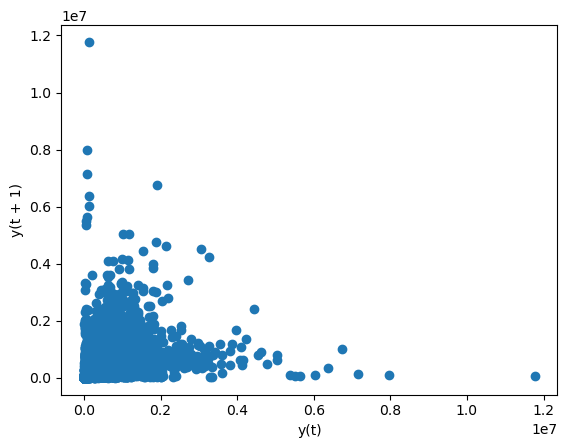

In [9]:
pd.plotting.lag_plot(df1[(df1.market_open)&(df1.symbol=='SPY')][['volume']], lag=1)

In [10]:
symbols = df1.symbol.unique()

In [11]:
# Check if the Datetime index is sorted
for sym in symbols:
    if df1[df1.symbol==sym].index.is_monotonic_increasing:
        print(f"The index is sorted for {sym}.")
    else:
        print(f"The index is not sorted for {sym}.")
        # df1.sort_index(inplace=True)


The index is sorted for QQQ.
The index is sorted for SPY.


### features

In [12]:
df1['time_delta'] = df1.reset_index().groupby('symbol')['us_eastern_timestamp'].diff().dt.total_seconds()

In [14]:
df1.reset_index().groupby('symbol')['us_eastern_timestamp'].diff().dt.total_seconds()

0          NaN
1         60.0
2         60.0
3         60.0
4         60.0
          ... 
429588    60.0
429589    60.0
429590    60.0
429591    60.0
429592    60.0
Name: us_eastern_timestamp, Length: 429593, dtype: float64

In [15]:
df1[df1.symbol=='SPY']

,symbol,open,high,low,close,volume,trade_count,vwap,market_open,time_delta
us_eastern_timestamp,,,,,,,,,,
2024-01-02 04:00:00,SPY,476.25,476.36,476.00,476.31,20460.0,84.0,476.301058,False,NaN
2024-01-02 04:01:00,SPY,476.34,476.34,476.29,476.29,6369.0,16.0,476.320154,False,NaN
2024-01-02 04:02:00,SPY,476.29,476.29,476.28,476.28,6152.0,10.0,476.280164,False,NaN
2024-01-02 04:03:00,SPY,476.27,476.27,476.27,476.27,369.0,10.0,476.270000,False,NaN
2024-01-02 04:04:00,SPY,476.27,476.27,476.27,476.27,369.0,10.0,476.270000,False,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-11-19 19:55:00,SPY,591.53,591.53,591.50,591.52,1052.0,23.0,591.509655,False,NaN
2024-11-19 19:56:00,SPY,591.52,591.54,591.48,591.48,3823.0,47.0,591.498801,False,NaN
2024-11-19 19:57:00,SPY,591.46,591.46,591.41,591.42,3656.0,30.0,591.429199,False,NaN


In [ ]:
fields = ['open', 'high', 'low', 'close', 'volume', 'vwap']
for field in fields:
    df1[f'{field}_diff'] = df1.groupby('symbol')[field].diff()

In [15]:
df1

,symbol,open,high,low,close,volume,trade_count,vwap,market_open,time_delta,open_diff,high_diff,low_diff,close_diff,volume_diff,vwap_diff
us_eastern_timestamp,,,,,,,,,,,,,,,,
2024-01-02 04:00:00,QQQ,409.84,409.84,409.76,409.79,1541.0,26.0,409.799268,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-02 04:01:00,QQQ,409.81,409.81,409.75,409.75,604.0,11.0,409.776912,False,NaN,-0.03,-0.03,-0.01,-0.04,-937.0,-0.022356
2024-01-02 04:02:00,QQQ,409.71,409.71,409.68,409.68,1510.0,9.0,409.689310,False,NaN,-0.10,-0.10,-0.07,-0.07,906.0,-0.087602
2024-01-02 04:03:00,QQQ,409.71,409.71,409.66,409.66,2679.0,18.0,409.697663,False,NaN,0.00,0.00,-0.02,-0.02,1169.0,0.008353
2024-01-02 04:04:00,QQQ,409.63,409.63,409.61,409.61,343.0,6.0,409.623333,False,NaN,-0.08,-0.08,-0.05,-0.05,-2336.0,-0.074330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19 19:55:00,SPY,591.53,591.53,591.50,591.52,1052.0,23.0,591.509655,False,NaN,0.00,0.00,0.00,0.00,0.0,0.000000
2024-11-19 19:56:00,SPY,591.52,591.54,591.48,591.48,3823.0,47.0,591.498801,False,NaN,-0.01,0.01,-0.02,-0.04,2771.0,-0.010854
2024-11-19 19:57:00,SPY,591.46,591.46,591.41,591.42,3656.0,30.0,591.429199,False,NaN,-0.06,-0.08,-0.07,-0.06,-167.0,-0.069602


### for all

In [16]:
for path in paths:
    print(path)
    df1 = pd.read_parquet(path)
    df1 = df1.reset_index().sort_values(by=['symbol', 'us_eastern_timestamp']).set_index('us_eastern_timestamp')
    symbols = df1.symbol.unique()
    # Check if the Datetime index is sorted
    for sym in symbols:
        if df1[df1.symbol==sym].index.is_monotonic_increasing:
            print(f"The index is sorted for {sym}.")
        else:
            print(f"The index is not sorted for {sym}.")
            raise IndexError
    df1['time_delta'] = df1.reset_index().groupby('symbol')['us_eastern_timestamp'].diff().dt.total_seconds()
    fields = ['open', 'high', 'low', 'close', 'volume', 'vwap']
    fields = [f for f in fields if f in df1.columns]
    for field in fields:
        df1[f'{field}_diff'] = df1.groupby('symbol')[field].diff()
    loc = path.replace('data_prep', 'reduced_autocorelation')
    df1.to_parquet(loc)
    print(f'Saved to {loc}.')

s3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_100D.parquet
The index is sorted for QQQ.
The index is sorted for SPY.
Saved to s3://sisyphus-general-bucket/AthenaInsights/latest_data/reduced_autocorelation/stock_bars_100D.parquet.
s3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_10D.parquet
The index is sorted for QQQ.
The index is sorted for SPY.
Saved to s3://sisyphus-general-bucket/AthenaInsights/latest_data/reduced_autocorelation/stock_bars_10D.parquet.
s3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_10min.parquet
The index is sorted for QQQ.
The index is sorted for SPY.
Saved to s3://sisyphus-general-bucket/AthenaInsights/latest_data/reduced_autocorelation/stock_bars_10min.parquet.
s3://sisyphus-general-bucket/AthenaInsights/latest_data/data_prep/stock_bars_120min.parquet
The index is sorted for QQQ.
The index is sorted for SPY.
Saved to s3://sisyphus-general-bucket/AthenaInsights/latest_data/re